loading the datasets , trying to sort it , analysing it.

In [ ]:
import pandas as pd
import glob

# 1. Load and Merge
files = glob.glob('*.csv')
df_total = pd.concat([pd.read_csv(f, low_memory=False) for f in files], ignore_index=True)

# 2. Quick Cleaning: removing rows without text or categories
df_total = df_total.dropna(subset=['reviews.text', 'categories'])

# 3. Analyze Categories
print("Number of unique categories:", df_total['categories'].nunique())
print("\nTop 10 most frequent categories:")
print(df_total['categories'].value_counts().head(10))

# Convert to lowercase to ensure no words are missed during mapping

Nombre de catégories uniques : 111

Top 10 des catégories les plus fréquentes :
categories
Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               10966
AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,House

In [3]:
# def map_meta_categories(cat_string):
#     cat_string = str(cat_string).lower() # On met tout en minuscule pour ne pas rater de mots
    
#     if 'tablet' in cat_string:
#         return 'Tablets'
#     elif 'battery' in cat_string or 'aa' in cat_string:
#         return 'Batteries'
#     elif 'echo' in cat_string or 'speaker' in cat_string or 'home automation' in cat_string:
#         return 'Smart Home & Speakers'
#     elif 'fire tv' in cat_string or 'streaming' in cat_string:
#         return 'Streaming & TV'
#     elif 'kindle' in cat_string or 'reader' in cat_string:
#         return 'E-Readers'
#     else:
#         return 'Other/Accessories'

# # On applique la fonction sur notre DataFrame fusionné
# df_total['meta_category'] = df_total['categories'].apply(map_meta_categories)

# # On vérifie le résultat
# print("Répartition de tes nouvelles méta-catégories :")
# print(df_total['meta_category'].value_counts())

In [4]:
# def map_refined_categories(row):
#     cat_string = str(row['categories']).lower()
#     name_string = str(row['name']).lower() # On regarde aussi le nom du produit !
    
#     # 1. Séparer les tablettes Kids des normales
#     if 'tablet' in cat_string:
#         if 'kids' in name_string or 'edition' in name_string:
#             return 'Kids Tablets'
#         return 'Standard Tablets'
    
#     # 2. Le reste reste identique
#     elif 'battery' in cat_string or 'aa' in cat_string:
#         return 'Batteries'
#     elif 'echo' in cat_string or 'speaker' in cat_string:
#         return 'Smart Home & Speakers'
#     elif 'fire tv' in cat_string or 'streaming' in cat_string:
#         return 'Streaming & TV'
#     elif 'kindle' in cat_string or 'reader' in cat_string:
#         return 'E-Readers'
#     else:
#         return 'Other'

# # Appliquer sur le DataFrame (attention, on passe 'axis=1' pour lire plusieurs colonnes)
# df_total['meta_category'] = df_total.apply(map_refined_categories, axis=1)

In [5]:
# 1. On applique la fonction affinée
# df_total['meta_category'] = df_total.apply(map_refined_categories, axis=1)

# # 2. On affiche le résultat pour voir la nouvelle répartition
# print("Nouvelle répartition avec distinction Kids/Standard :")
# print(df_total['meta_category'].value_counts())

# # 3. Petit test pour vérifier si ça a bien marché
# print("\nExemples de produits classés en 'Kids Tablets' :")
# print(df_total[df_total['meta_category'] == 'Kids Tablets']['name'].unique()[:3])

In [ ]:
def final_clean_mapping(row):
    name = str(row['name']).lower()
    cat_string = str(row['categories']).lower()
    
    # 1. SMART HOME
    if 'echo' in cat_string or 'speaker' in cat_string:
        return 'Smart Home & Speakers'
    
    # 2. BATTERIES
    elif 'battery' in cat_string or 'aa' in cat_string:
        return 'Batteries'
    
    # 3. STREAMING
    elif 'fire tv' in cat_string or 'streaming' in cat_string:
        return 'Streaming & TV'
    
    # 4. TABLETS (with specific size/version splits)
    elif 'tablet' in cat_string:
        if 'kids' in name or 'edition' in name:
            return 'Kids Tablets'
        elif '10' in name:
            return 'Tablets Max (10")'
        elif '8' in name:
            return 'Tablets Med (8")'
        else:
            return 'Tablets Mini (7")'
            
    return 'TO_DROP'

# Apply the final mapping version
df_total['meta_category'] = df_total.apply(final_clean_mapping, axis=1)

# Drop rows that are not within our target categories
df_final = df_total[df_total['meta_category'] != 'TO_DROP'].copy()

print("Final distribution:")
print(df_final['meta_category'].value_counts())

Ta répartition finale  :
meta_category
Tablets Med (8")         22306
Batteries                12071
Tablets Mini (7")        10914
Smart Home & Speakers     9559
Kids Tablets              7302
Streaming & TV            5107
Tablets Max (10")          205
Name: count, dtype: int64


In [ ]:
# 1. Define the list of categories to keep (using the current name: 'meta_category')
target_categories = [
    'Tablets Med (8")', 
    'Batteries', 
    'Tablets Mini (7")', 
    'Smart Home & Speakers', 
    'Kids Tablets', 
    'Streaming & TV'
]

# 2. Filter based on 'meta_category' first
df_ready = df_total[df_total['meta_category'].isin(target_categories)].copy()

# 3. Remove empty review texts
df_ready = df_ready.dropna(subset=['reviews.text'])

# 4. Select and rename columns for clarity
df_ready = df_ready[['name', 'reviews.text', 'reviews.rating', 'meta_category']]
df_ready.columns = ['product_name', 'review_text', 'rating', 'category']

# 5. Define sentiments based on ratings (Task 1)
def get_sentiment(rating):
    if rating >= 4: return 'positive'
    if rating == 3: return 'neutral'
    return 'negative'

df_ready['sentiment'] = df_ready['rating'].apply(get_sentiment)

print(f"Success! Dataset ready with {len(df_ready)} rows.")
print(df_ready['category'].value_counts())

✅ Succès ! Dataset prêt avec 67259 lignes.
category
Tablets Med (8")         22306
Batteries                12071
Tablets Mini (7")        10914
Smart Home & Speakers     9559
Kids Tablets              7302
Streaming & TV            5107
Name: count, dtype: int64


C:\Users\rache\AppData\Local\Temp\ipykernel_25976\3072944493.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


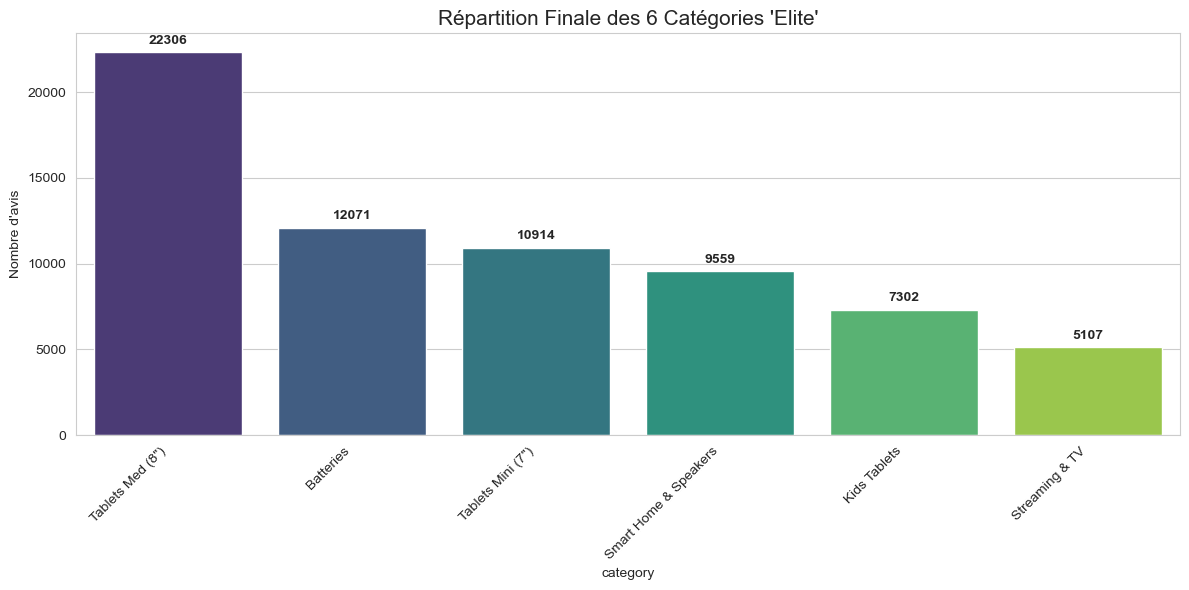

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ensure we use df_ready (the version without the 205 'Tablets Max' entries)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 2. Calculate counts from the processed dataframe
counts = df_ready['category'].value_counts()

# 3. Bar plot creation
sns.barplot(x=counts.index, y=counts.values, palette="viridis")

# 4. Formatting and styling
plt.title("Final Distribution of the 6 'Elite' Categories", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Reviews")

# Display numerical values above bars for precision
for i, v in enumerate(counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import glob

# 1. Load and Merge
# Gathering all CSV files in the current directory
files = glob.glob('*.csv')
df_total = pd.concat([pd.read_csv(f, low_memory=False) for f in files], ignore_index=True)

# 2. Quick Cleaning: remove rows without text or category labels
df_total = df_total.dropna(subset=['reviews.text', 'categories'])

# 3. Analyze Categories
print("Number of unique categories:", df_total['categories'].nunique())
print("\nTop 10 most frequent categories:")
print(df_total['categories'].value_counts().head(10))

Nombre de catégories uniques : 111

Top 10 des catégories les plus fréquentes :
categories
Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               10966
AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,House

In [ ]:
# Check for reviews with a 1-star rating (Negative) that might actually be positive
print("Examples of 1/5 rated reviews (potentially contradictory):")
contradictions = df_ready[df_ready['rating'] == 1]['review_text'].head(10)
for i, text in enumerate(contradictions):
    print(f"{i+1}. {text[:150]}...") # Display the first 150 characters

Exemples d'avis notés 1/5 (potentiellement contradictoires) :
1. i Bought this around black friday for $60 hoping it would be awesome... it failed so hard i tried multiple different micro SD cards none of which were...
2. I bought this tablet for my 4 year old daughter. Too many advertisements. I would rather pay more and not have a single ad....
3. Didn't want to go to the sites amazon wanted me to....
4. This Kindle is so overloaded with apps that I will never use. Despite what one of Best Buys' associates said, you cannot remove any of the Amazon apps...
5. I liked it at first except the browser is kind of clunky. Also you can. It use all android Apps. The worst thing though was mine just stopped working ...
6. If ads dont bother you, then this may be a decent device. Purchased this for my kid and it was loaded down with so much spam, it kept loading it up ma...
7. not good, hate it , never buy it again, sucks. done...
8. This is not a bad product. Amazon offers greats products but 

C:\Users\rache\AppData\Local\Temp\ipykernel_25976\3948404869.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_ready, x='rating', palette='magma')


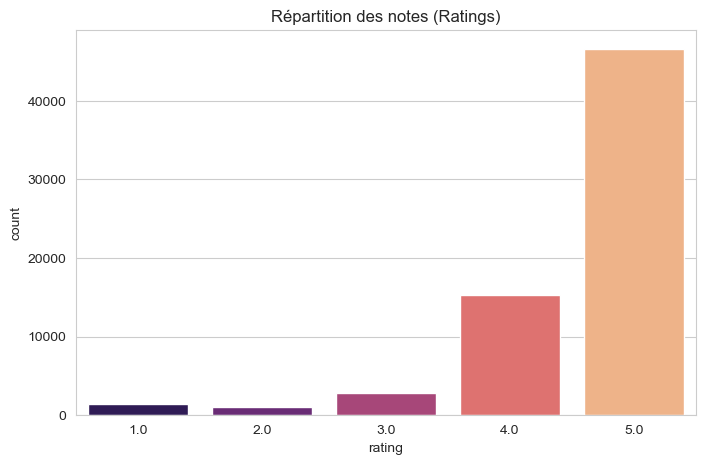

In [ ]:
# Visualize the distribution of ratings (1 to 5)
plt.figure(figsize=(8, 5))
sns.countplot(data=df_ready, x='rating', palette='magma')
plt.title("Distribution of Ratings")
plt.show()

In [ ]:
import re  
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def prepare_for_nlp(text):
    # 1. Basic cleaning
    # Remove special characters and keep only lowercase letters and spaces
    text = re.sub(r'[^a-z\s]', '', str(text).lower())
    
    # 2. Stop words removal (removing common words that add little meaning)
    words = text.split()
    cleaned_words = [w for w in words if w not in stop_words]
    return " ".join(cleaned_words)

# Create a new column for the processed NLP text
df_ready['nlp_text'] = df_ready['review_text'].apply(prepare_for_nlp)

print("BEFORE:", df_ready['review_text'].iloc[0])
print("AFTER:", df_ready['nlp_text'].iloc[0])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rache\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AVANT : This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.
APRÈS : product far disappointed children love use like ability monitor control content see ease


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Configure the vectorizer
# max_features=5000: Keep the top 5000 most important words/bigrams
# ngram_range=(1, 2): Analyze both single words and pairs of words (unigrams and bigrams)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# 2. Transform the processed text (nlp_text) into numerical features
X = tfidf.fit_transform(df_ready['nlp_text'])

# 3. Define the target variable (the labels we want to predict)
y = df_ready['sentiment']

print(f"Matrix created: {X.shape[0]} reviews and {X.shape[1]} unique features (words/bigrams) analyzed.")

Matrice créée : 67259 avis et 5000 mots/paires de mots analysés.


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%) sets
# random_state=42 ensures the results are reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} reviews")
print(f"Testing set: {X_test.shape[0]} reviews")

Entraînement : 53807 avis
Test : 13452 avis


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Initialize the model
# max_iter=1000 ensures the solver has enough iterations to converge
model = LogisticRegression(max_iter=1000)

# 2. Train the model (this is where the magic happens)
model.fit(X_train, y_train)

# 3. Predict sentiments on the test set (Inference)
y_pred = model.predict(X_test)

# 4. Review and evaluate the results
print(f"Global Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report by Sentiment:")
print(classification_report(y_test, y_pred))

Précision globale : 93.76%

Détails par sentiment :
              precision    recall  f1-score   support

    negative       0.81      0.44      0.57       482
     neutral       0.59      0.12      0.21       600
    positive       0.94      1.00      0.97     12370

    accuracy                           0.94     13452
   macro avg       0.78      0.52      0.58     13452
weighted avg       0.92      0.94      0.92     13452



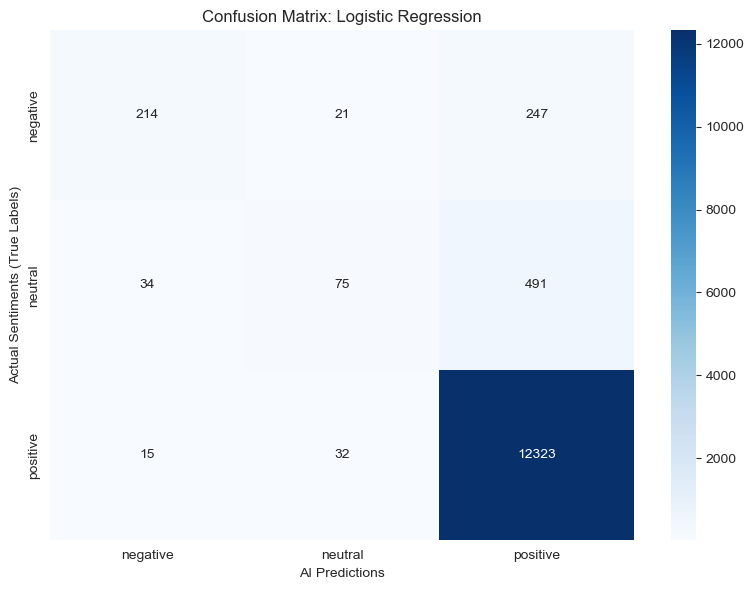

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate the confusion matrix
# Defining the labels ensures the order is logical on the graph (negative to positive)
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# 2. Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'])

# 3. Add formatting and labels
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('AI Predictions')
plt.ylabel('Actual Sentiments (True Labels)')

# 4. Display the plot
plt.tight_layout()
plt.show()

Downsampling

In [ ]:
# 1. Separate classes to handle imbalance
df_pos = df_ready[df_ready['sentiment'] == 'positive']
df_neg = df_ready[df_ready['sentiment'] == 'negative']
df_neu = df_ready[df_ready['sentiment'] == 'neutral']

# 2. Set an equal sample size for each class (Undersampling)
# We take the minimum size between the classes, capped at 3000 for efficiency
n_samples = min(len(df_neg), len(df_neu), 3000) 

df_balanced = pd.concat([
    df_pos.sample(n_samples, random_state=42),
    df_neg.sample(n_samples, random_state=42),
    df_neu.sample(n_samples, random_state=42)
])

# 3. Rerun TF-IDF vectorization on the balanced dataset
X_bal = tfidf.fit_transform(df_balanced['nlp_text'])
y_bal = df_balanced['sentiment']

# 4. New Train/Test Split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# 5. Train the balanced model
model_balanced = LogisticRegression(max_iter=1000)
model_balanced.fit(X_train_b, y_train_b)

# 6. Evaluate final performance
y_pred_b = model_balanced.predict(X_test_b)
print("--- NEW BALANCED CLASSIFICATION REPORT ---")
print(classification_report(y_test_b, y_pred_b))

--- NOUVEAU RAPPORT ÉQUILIBRÉ ---
              precision    recall  f1-score   support

    negative       0.80      0.78      0.79       474
     neutral       0.68      0.69      0.69       493
    positive       0.80      0.81      0.81       517

    accuracy                           0.76      1484
   macro avg       0.76      0.76      0.76      1484
weighted avg       0.76      0.76      0.76      1484



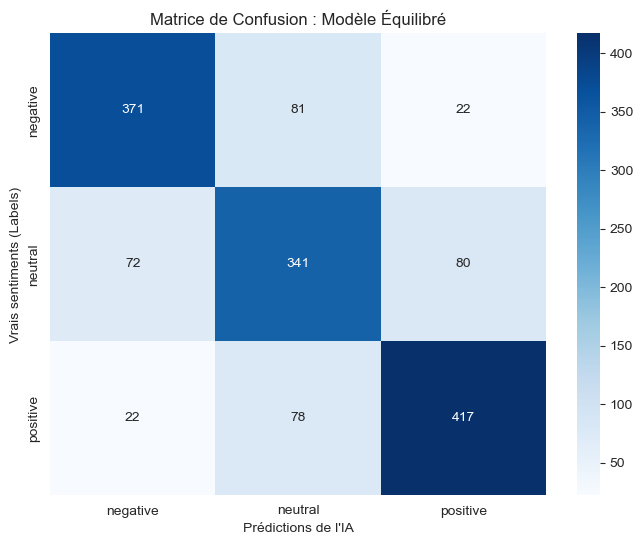

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Calculate the confusion matrix
# We specify the labels to ensure the order is consistent on the axes
cm = confusion_matrix(y_test_b, y_pred_b, labels=['negative', 'neutral', 'positive'])

# 2. Display the matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'])

plt.xlabel('AI Predictions')
plt.ylabel('Actual Sentiments (Labels)')
plt.title('Confusion Matrix: Balanced Model')
plt.show()

In [ ]:
# 1. Transform the ENTIRE text dataset (67k rows) using the pre-trained vectorizer
X_all = tfidf.transform(df_ready['nlp_text'])

# 2. Use the AI model to predict the sentiment for every row (Inference phase)
df_ready['predicted_sentiment'] = model_balanced.predict(X_all)

# 3. Check if the distribution of AI-predicted sentiments differs from the original ratings
print("--- Distribution of AI-Predicted Sentiments ---")
print(df_ready['predicted_sentiment'].value_counts())

# 4. Verify results for a specific category (e.g., Batteries)
print("\n--- Sentiment Breakdown for the 'Batteries' Category ---")
print(df_ready[df_ready['category'] == 'Batteries']['predicted_sentiment'].value_counts())

--- Répartition des sentiments prédits par l'IA ---
predicted_sentiment
positive    47976
neutral     12887
negative     6396
Name: count, dtype: int64

--- Exemple pour la catégorie Batteries ---
predicted_sentiment
positive    6471
negative    3254
neutral     2346
Name: count, dtype: int64


saving the model i already have with linear regression + tf idf ngram(1-2)

In [ ]:
import joblib

# 1. Save the sentiment analysis model
# This persists the trained Logistic Regression model to a file
joblib.dump(model_balanced, 'sentiment_model_logicReg.pkl')

# 2. Save the TF-IDF vectorizer (CRITICAL STEP)
# The vectorizer is essential to transform future text inputs into the same feature space
joblib.dump(tfidf, 'tfidf_ng1-2_vectorizer.pkl')

print("Models saved successfully! (.pkl files created)")

Modèles sauvegardés avec succès ! (Fichiers .pkl créés)


Naïve Bayes now with tf-idf and all the same preprocess before 

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# 1. Initialize the Multinomial Naive Bayes model
# We use Multinomial because it is well-suited for word frequencies (TF-IDF)
nb_model = MultinomialNB()

# 2. Train the model on the balanced dataset
nb_model.fit(X_train_b, y_train_b)

# 3. Predict on the test set
y_pred_nb = nb_model.predict(X_test_b)

# 4. Display the performance report
print("--- NAIVE BAYES RESULTS ---")
print(classification_report(y_test_b, y_pred_nb))

# 5. Compare the scores
score_logic = model_balanced.score(X_test_b, y_test_b)
score_nb = nb_model.score(X_test_b, y_test_b)

print(f"Global Accuracy Logistic Regression : {score_logic:.4f}")
print(f"Global Accuracy Naive Bayes         : {score_nb:.4f}")

--- RÉSULTATS NAÏVE BAYES ---
              precision    recall  f1-score   support

    negative       0.75      0.77      0.76       474
     neutral       0.68      0.61      0.65       493
    positive       0.76      0.81      0.78       517

    accuracy                           0.73      1484
   macro avg       0.73      0.73      0.73      1484
weighted avg       0.73      0.73      0.73      1484

Précision globale Régression Logistique : 0.7608
Précision globale Naïve Bayes          : 0.7325


In [ ]:
import joblib

# 1. Save the Naive Bayes model (the one using TF-IDF 1-2)
# We name it 'sentiment_model_nb.pkl' to distinguish it from the Logistic Regression model
joblib.dump(nb_model, 'sentiment_model_nb.pkl')

# Note: You don't necessarily need to save the TF-IDF vectorizer a second time 
# if it is exactly the same one used for Logistic Regression.
# However, just to be safe, we can save it under a specific name for this model:
joblib.dump(tfidf, 'tfidf_ng1-3_vectorizer_final.pkl')

print("Naive Bayes model and Vectorizer saved successfully!")

Modèle Naïve Bayes et Vectoriseur sauvegardés !


so now i will try to use a N gram of (1-3) because i feel like it can maybe detect more good or bad reviews 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# 1. Recreate the vectorizer using trigrams (1, 3)
# ngram_range=(1, 3) captures single words, bigrams, and trigrams
# stop_words='english' removes common words that add no predictive value
tfidf_v3 = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), stop_words='english')

# 2. Transform the balanced dataset again
# (Reusing the df_balanced dataframe created in the previous steps)
X_v3 = tfidf_v3.fit_transform(df_balanced['nlp_text'])
y_v3 = df_balanced['sentiment']

# 3. New Train/Test Split
X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_v3, y_v3, test_size=0.2, random_state=42)

print("New vocabulary with Trigrams created successfully!")

Nouveau dictionnaire avec Trigrams créé !


the Naïve Bayes  with the new N gram and tf idf 

In [ ]:
# 1. Initialize the new Naive Bayes model
nb_model_v3 = MultinomialNB()

# 2. Train the model on the updated trigram data
nb_model_v3.fit(X_train_v3, y_train_v3)

# 3. Predict on the test set
y_pred_v3 = nb_model_v3.predict(X_test_v3)

# 4. Evaluate the results
print("--- NAIVE BAYES RESULTS (N-GRAMS 1-3) ---")
print(classification_report(y_test_v3, y_pred_v3))

--- RÉSULTATS NAÏVE BAYES (N-GRAMS 1-3) ---
              precision    recall  f1-score   support

    negative       0.74      0.76      0.75       474
     neutral       0.67      0.59      0.63       493
    positive       0.75      0.81      0.78       517

    accuracy                           0.72      1484
   macro avg       0.72      0.72      0.72      1484
weighted avg       0.72      0.72      0.72      1484



Random Forest TF-IDF n gram  (1, 2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Initialization (limiting the depth to prevent memory overload)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

# 2. Training on the balanced dataset
rf_model.fit(X_train_b, y_train_b)

# 3. Prediction on the test set
y_pred_rf = rf_model.predict(X_test_b)

# 4. Evaluation results
print("--- RANDOM FOREST RESULTS ---")
print(classification_report(y_test_b, y_pred_rf))

# 5. Final model comparison
score_logic = model_balanced.score(X_test_b, y_test_b)
score_rf = rf_model.score(X_test_b, y_test_b)

print(f"Logistic Regression Accuracy : {score_logic:.4f}")
print(f"Random Forest Accuracy       : {score_rf:.4f}")

--- RÉSULTATS RANDOM FOREST ---
              precision    recall  f1-score   support

    negative       0.73      0.79      0.76       474
     neutral       0.65      0.65      0.65       493
    positive       0.78      0.73      0.75       517

    accuracy                           0.72      1484
   macro avg       0.72      0.72      0.72      1484
weighted avg       0.72      0.72      0.72      1484

Précision Logistique : 0.7608
Précision Random Forest : 0.7210


In [ ]:
import joblib
import pandas as pd

# 1. Load the Vectorizer (the tool that transforms text into numerical features)
tfidf = joblib.load('tfidf_ng1-2_vectorizer.pkl')

# 2. Load your best model (Logistic Regression)
model_balanced = joblib.load('sentiment_model_logicReg.pkl')

# 3. Load your second model (Naive Bayes) if needed for comparison
# nb_model = joblib.load('sentiment_model_nb.pkl')

print("Models and Vectorizer loaded successfully!")

✅ Modèles et Vectoriseur chargés avec succès !


--- PERFORMANCE GLOBALE SUR L'ENSEMBLE DU DATASET (67k) ---
              precision    recall  f1-score   support

    negative       0.33      0.85      0.47      2473
     neutral       0.17      0.72      0.28      2858
    positive       0.99      0.78      0.87     61928

    accuracy                           0.78     67259
   macro avg       0.50      0.78      0.54     67259
weighted avg       0.93      0.78      0.83     67259



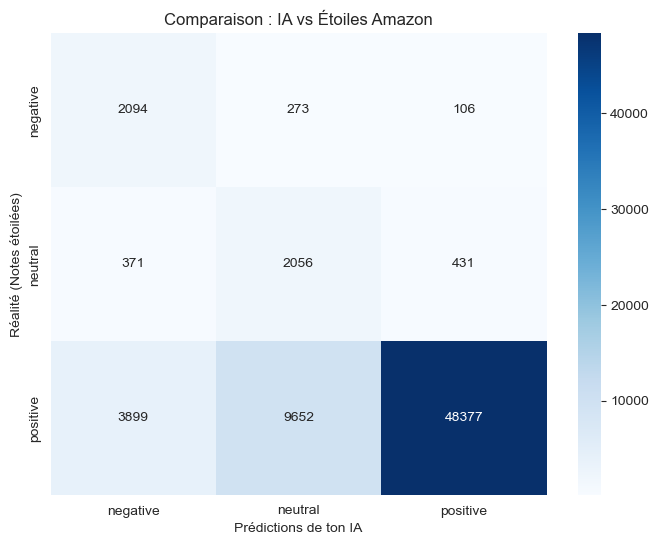

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Transform the entire dataset (67k rows)
# We use the vectorizer that has already learned the vocabulary
X_global = tfidf.transform(df_ready['review_text'])
y_global = df_ready['sentiment'] 

# 2. Predict using your champion model (Logistic Regression)
y_pred_global = model_balanced.predict(X_global)

# 3. Display the results
print("--- GLOBAL PERFORMANCE ON THE ENTIRE DATASET (67k) ---")
print(classification_report(y_global, y_pred_global))

# 4. Confusion Matrix (Visual for your presentation)
cm = confusion_matrix(y_global, y_pred_global)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('AI Predictions')
plt.ylabel('Reality (Star Ratings)')
plt.title('Comparison: AI vs Amazon Stars')
plt.show()

testing the clustering on the whole data set first 

In [ ]:
from sklearn.cluster import KMeans

# 1. Run K-Means on the ENTIRE dataset (using the previously computed X_global)
# We set n_clusters=5 to discover 5 major themes/topics
kmeans_global = KMeans(n_clusters=5, random_state=42, n_init=10)

# Create a new column in df_ready to store the assigned cluster ID for each review
df_ready['cluster_id'] = kmeans_global.fit_predict(X_global)

# 2. Display the defining keywords for each group
print("--- THE 5 MAJOR THEMES DISCOVERED (GLOBAL CLUSTERING) ---")
order_centroids = kmeans_global.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(5):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_words)}")

--- LES 5 GRANDS THÈMES DÉCOUVERTS (CLUSTERING GLOBAL) ---
Cluster 0 : great, price, great price, tablet, great product, product, works great, great tablet, works, easy
Cluster 1 : loves, old, year old, year, bought, tablet, daughter, son, easy, gift
Cluster 2 : good, price, good price, batteries, tablet, good product, good batteries, product, good value, good tablet
Cluster 3 : love, kindle, easy, great, kids, use, tablet, fire, kids love, one
Cluster 4 : use, easy, tablet, batteries, kindle, amazon, one, like, fire, bought


In [ ]:
from sklearn.cluster import KMeans

# 1. Ensure the AI has labeled the entire dataset
# Transform the text and predict the sentiment
X_all = tfidf.transform(df_ready['review_text'])
df_ready['predicted_sentiment'] = model_balanced.predict(X_all)

# 2. Now isolate the strictly negative reviews
df_neg = df_ready[df_ready['predicted_sentiment'] == 'negative'].copy()

# 3. Prepare the data for clustering (using only negative texts)
X_neg = tfidf.transform(df_neg['review_text'])

# 4. Run K-Means clustering to find the main issues (3 clusters)
km_neg = KMeans(n_clusters=3, random_state=42, n_init=10)
df_neg['problem_cluster'] = km_neg.fit_predict(X_neg)

# 5. Display the results to analyze the core complaints
print("--- THE 3 MAIN ISSUES IDENTIFIED ---")
order_centroids = km_neg.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()

for i in range(3):
    top_words = [terms[ind] for ind in order_centroids[i, :12]]
    print(f"\nIssue Cluster {i}:")
    print(f" {', '.join(top_words)}")

--- LES 3 PRINCIPAUX PROBLÈMES IDENTIFIÉS ---

Problème Type 0 :
👉 work, batteries, half, cheap, say, fine, well, last, make, simple, know, expected

Problème Type 1 :
👉 batteries, last, long, brand, name, amazon, buy, good, work, name brand, aa, brands

Problème Type 2 :
👉 amazon, buy, one, would, product, use, tablet, bought, battery, last, charge, get


Qwen/Qwen2.5-3B-Instruct

In [ ]:
from transformers import pipeline
import torch

# Chargement du modèle sur ta carte graphique (device=0)
local_generator = pipeline(
    "text-generation", 
    model="Qwen/Qwen2.5-3B-Instruct", 
    device=0, 
    torch_dtype=torch.float16,
    trust_remote_code=True
)

def generer_article_local(categorie, df, problemes):
    print(f" Local Generation (RTX 5070) for: {categorie}...")
    
    # On récupère les bons avis comme pour Gemini pour avoir la même qualité
    bons_avis = df[(df['category'] == categorie) & (df['predicted_sentiment'] == 'positive')]['review_text'].head(3).tolist()
    
    # Prompt structuré pour le modèle local
    messages = [
        {"role": "system", "content": "You are a professional tech blogger. Write a concise and helpful buyer's guide (150 words)."},
        {"role": "user", "content": f"""
        Write a review for the category: {categorie}
        
        People love these aspects: {bons_avis}
        But some complained about: {problemes}
        
        Structure the article with a catchy title and a clear 'Verdict' section at the end.
        """}
    ]
    
    prompt = local_generator.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = local_generator(prompt, max_new_tokens=450, do_sample=True, temperature=0.7)
    
    # Nettoyage de la réponse pour ne garder que le texte de l'assistant
    generated_text = outputs[0]['generated_text']
    return generated_text.split("<|im_start|>assistant\n")[-1].replace("<|im_end|>", "").strip()

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

c:\Users\rache\anaconda3\envs\travail_cnn\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rache\.cache\huggingface\hub\models--Qwen--Qwen2.5-3B-Instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [28]:
%pip install transformers torch accelerate

  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-win_amd64.whl.metadata (7.4 kB)
  Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl.metadata (4.2 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl.metadata (5.0 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached annotated_doc-0.0.4-py3-none-any.whl.metadata (6.6 kB)
   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ------ --------------------------------- 1.6/10.4 MB 8.4 MB/s eta 0:00:02
   -------------- ------------------------- 3.7/10.4 MB 9.5 MB/s eta 0:00:01
   ---------------------- ----------------- 5.8/10.4 MB 10.1 MB/s eta 0:00:01
   ------------------------------- -------- 8.1/10.4 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 10.3 MB/s  0:00:01
Using cached huggingface_hub-1.4.1-py3-none-

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


so now the api  with gemini

In [15]:
!pip install python-dotenv google-generativeai

INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 9.8 MB/s  0:00:00
   ---------------------------------------- 0.0/14.7 MB ? eta -:--:--
   -------- ------------------------------- 3.1/14.7 MB 15.4 MB/s eta 0:00:01
   --------------- ------------------------ 5.8/14.7 MB 14.1 MB/s eta 0:00:01
   ------------------------ --------------- 8.9/14.7 MB 14.6 MB/s eta 0:00:01
   ----------------------------- ---------- 11.0/14.7 MB 13.5 MB/s eta 0:00:01
   ------------------------------------ --- 13.4/14.7 MB 12.9 MB/s eta 0:00:01
   ---------------------------------------- 14.7/14.7 MB 12.5 MB/s  0:00:01

  Attempting 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.6 which is incompatible.


In [17]:
!pip install -U google-generativeai

In [31]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

print("Modèles disponibles pour la génération de texte :")
for m in genai.list_models():
    if 'generateContent' in m.supported_generation_methods:
        print(m.name)

C:\Users\rache\AppData\Local\Temp\ipykernel_25976\4206133438.py:1: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


Modèles disponibles pour la génération de texte :
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-flash-preview
models/gemini-3.1-pro-preview
models/gemini-3.1-pro-preview-customtools
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robotics-er-1.5-preview
models/gemini-2.5-computer-use-preview-10-2025
models/deep-research-pro-preview-12-2025


In [ ]:
import time
import google.generativeai as genai
import os
from dotenv import load_dotenv

# 1. Load the API key and configure the correct Gemini model
load_dotenv()
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
model = genai.GenerativeModel('gemini-2.5-flash')

# 2. Retrieve the keywords from the 3 negative clusters (to feed to the LLM)
negative_keywords = []
for i in range(3):
    # Extract the top 5 most important words from each cluster
    top_words = [terms[ind] for ind in order_centroids[i, :5]]
    negative_keywords.append(", ".join(top_words))

problem_summary = " | ".join(negative_keywords)

# 3. The function that constructs the prompt and calls the Gemini API
def generate_gemini_article(category, df, problems):
    print(f"Generating cloud article (Gemini) for: {category}...")
    
    # Fetch 3 random positive reviews for this category to show the pros
    good_reviews = df[(df['category'] == category) & (df['predicted_sentiment'] == 'positive')]['review_text'].head(3).tolist()
    
    # The structured prompt is written in English to ensure high-quality generation
    prompt = f"""
    You are an expert tech copywriter and blogger. Write a short blog post (around 150 words) 
    that gives an honest review and recommendation for the product category: "{category}".
    
    Here is what customers love (examples of real positive reviews):
    {good_reviews}
    
    Here are the main flaws reported by unhappy customers (keywords extracted from our K-Means clustering):
    {problems}
    
    Write a catchy, well-structured (with a title) and professional article. 
    The goal is to help a potential buyer weigh the pros and cons before making a purchase.
    """
    
    # Call the Gemini API
    response = model.generate_content(prompt)
    return response.text

# 4. Test the pipeline on the first available category
test_category = df_ready['category'].dropna().unique()[0] 
article = generate_gemini_article(test_category, df_ready, problem_summary)

print("\n" + "="*50 + "\n")
print(article)

⏳ Generating article for: Tablets Med (8")...


## 8-inch Tablets: Budget Bliss or Battery Blues?

Thinking about an 8-inch tablet? These often deliver surprising value. Customers love their **ease of use**, perfect for kids with **simple parental controls**, or as a thoughtful gift. For media fans, especially Prime members, they truly **shine**, offering vast content access and offline downloads. Many are impressed by the **crisp screens and solid build** for the price.

However, manage expectations. Some users report **inconsistent battery life**, not matching premium brands. Performance for demanding tasks can feel **sluggish**, with a few deeming them "cheap." Being tied to a specific ecosystem (like Amazon's) also isn't for everyone.

**Verdict:** Great for casual browsing, streaming, e-reading, and family entertainment. If affordability and content access outweigh raw power and all-day battery, an 8-inch tablet is a smart, honest choice.


In [ ]:
import pandas as pd
import time

# 1. Extract all unique categories from the dataset
# We use df_ready to ensure we only process clean data
all_categories = df_ready['category'].dropna().unique()
dual_articles = []

print("Launching hybrid generation pipeline...")

for cat in all_categories:
    try:
        # 1. Gemini (Cloud API) - passing the 3 variables: category, dataframe, problem summary
        text_gemini = generate_gemini_article(cat, df_ready, problem_summary)
        
        # 2. Qwen (Local GPU) - passing the exact same 3 variables for a fair comparison
        text_local = generate_local_article(cat, df_ready, problem_summary)
        
        # 3. Store the results in a dictionary
        dual_articles.append({
            "Category": cat,
            "Gemini_Article": text_gemini,
            "Local_Article": text_local
        })
        
        print(f"Success: Generated articles for {cat}")
        time.sleep(1) # Small pause to avoid hitting Cloud API rate limits
        
    except Exception as e:
        print(f"Error processing {cat}: {e}")

# 4. Final Export
df_articles = pd.DataFrame(dual_articles)
df_articles.to_csv("blog_articles.csv", index=False)
print("\nDONE! You can now refresh your Streamlit app.")

🚀 Launching hybrid generation...
⏳ Generating article for: Tablets Med (8")...


Passing `generation_config` together with generation-related arguments=({'do_sample', 'temperature', 'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.


⏳ Local Generation (RTX 5070) for: Tablets Med (8")...


Both `max_new_tokens` (=450) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


✅ Success: Tablets Med (8")
⏳ Generating article for: Tablets Mini (7")...


Both `max_new_tokens` (=450) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


⏳ Local Generation (RTX 5070) for: Tablets Mini (7")...
✅ Success: Tablets Mini (7")
⏳ Generating article for: Streaming & TV...


Both `max_new_tokens` (=450) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


⏳ Local Generation (RTX 5070) for: Streaming & TV...
✅ Success: Streaming & TV
⏳ Generating article for: Kids Tablets...


Both `max_new_tokens` (=450) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


⏳ Local Generation (RTX 5070) for: Kids Tablets...
✅ Success: Kids Tablets
⏳ Generating article for: Smart Home & Speakers...


Both `max_new_tokens` (=450) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


⏳ Local Generation (RTX 5070) for: Smart Home & Speakers...
✅ Success: Smart Home & Speakers
⏳ Generating article for: Batteries...


Both `max_new_tokens` (=450) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


⏳ Local Generation (RTX 5070) for: Batteries...
✅ Success: Batteries

🎉 DONE! You can now refresh your Streamlit app.
